# Кейс 9

#### Импортируем библиотеки

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 
import seaborn as sns
from matplotlib import pyplot as plt

#### Произведем обзор данных и преобразование данных за период с 01.06.2019 по 30.06.2019:

Получим данные из базы данных и определим количество пользователей, которые зарегистрировались в каждый день июня:

In [2]:
def getRegisteredUsersCount():
    query = """SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    """.format()
    conn = psycopg2.connect("""dbname=''
                             user='' 
                             host=''
                             password=''
                             port=5432""")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data


registered_users_count = pd.DataFrame(getRegisteredUsersCount()) 

Получим информацию о датафрейме:

In [3]:
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       30 non-null     object
 1   registered_users_count  30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 608.0+ bytes


Преобразуем колонку registration_date с типа object в тип datetime:

In [4]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])

In [5]:
registered_users_count.head() #оценим первые строки датафрейма

,registration_date,registered_users_count
0,2019-06-01,4833
1,2019-06-02,5255
2,2019-06-03,4193
3,2019-06-04,4194
4,2019-06-05,3998


Для определения количества пользователей, которые вернулись в игру в дальнейшем, мы можем посчитать количество активных пользователей в разрезе когорт. В этом случае в качестве когорты будет выступать дата регистрации. Таким образом, можно получить количество активных пользователей по дням в разрезе даты регистрации. 

In [6]:
def getActiveUsersCountWithCohorts():
    query = """SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    """.format()
    conn = psycopg2.connect("""dbname='' user='' host='' password='' port=5432""")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

Получим информацию о датафрейме:

In [7]:
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       930 non-null    object
 1   registration_date   930 non-null    object
 2   active_users_count  930 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.9+ KB


Колонки с датами преобразуем с тип object в тип datetime:

In [8]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

In [9]:
#Оценим первые строки датафрейма active_users_count_with_cohorts
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-06-01,2019-06-01,1651
1,2019-06-02,2019-06-01,1429
2,2019-06-02,2019-06-02,1933
3,2019-06-03,2019-06-01,1021
4,2019-06-03,2019-06-02,1550


### 1. Считаем Retention Rate

Объединим таблицы по выбранной колонке и запишем объединенные данные в датафрейм retention_table:

In [10]:
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-06-01,2019-06-01,1651,4833
1,2019-06-02,2019-06-01,1429,4833
2,2019-06-02,2019-06-02,1933,5255
3,2019-06-03,2019-06-01,1021,4833
4,2019-06-03,2019-06-02,1550,5255


Подсчитаем показатель retention_rate:

In [11]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-06-01,2019-06-01,1651,4833,0.341610
1,2019-06-02,2019-06-01,1429,4833,0.295676
2,2019-06-02,2019-06-02,1933,5255,0.367840
3,2019-06-03,2019-06-01,1021,4833,0.211256
4,2019-06-03,2019-06-02,1550,5255,0.294957


Подсчитаем показатель lifetime:

In [12]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу
retention_table['lifetime'].head()

0    0
1    1
2    0
3    2
4    1
Name: lifetime, dtype: int32

#### Сформируем сводную таблицу и для каждого дня lifetime рассчитаем усредненный Retention Rate по всем когортам июня 2019 г.:

In [13]:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')

retention_mean_by_lifetime = retention_pivot.mean()
print (retention_mean_by_lifetime)

lifetime
0     0.350607
1     0.305707
2     0.223304
3     0.186753
4     0.161584
5     0.144832
6     0.134225
7     0.125151
8     0.115505
9     0.106549
10    0.100147
11    0.094230
12    0.090701
13    0.087670
14    0.085370
15    0.080326
16    0.076764
17    0.073749
18    0.070988
19    0.068546
20    0.067471
21    0.065852
22    0.063643
23    0.060973
24    0.057966
25    0.056677
26    0.054686
27    0.053935
28    0.052781
29    0.040779
30    0.027130
dtype: float64


#### Построим график изменения среднего Retention Rate в июне 2019 в зависимости от времени жизни пользователя

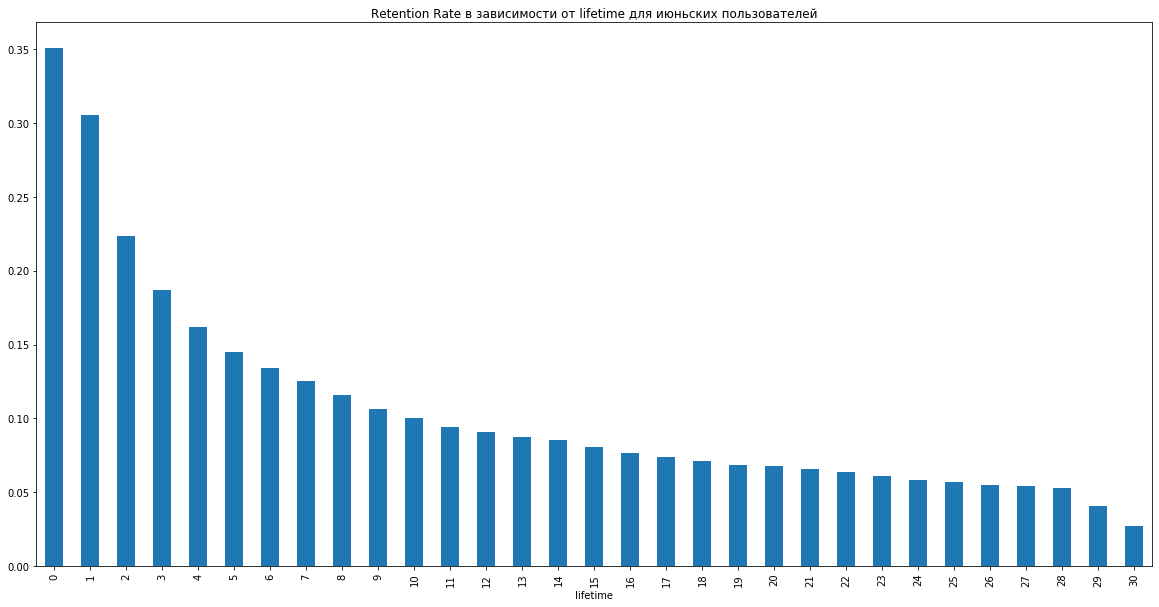

In [14]:
plt.figure(figsize=(20, 10))
plt.title('Retention Rate в зависимости от lifetime для июньских пользователей')
retention_mean_by_lifetime.plot.bar()

#### Вывод: 
Как видно по графику, retention rate убывает с течением времени. Особенно заметны резкие падения на 2, 29 и 30 день. 

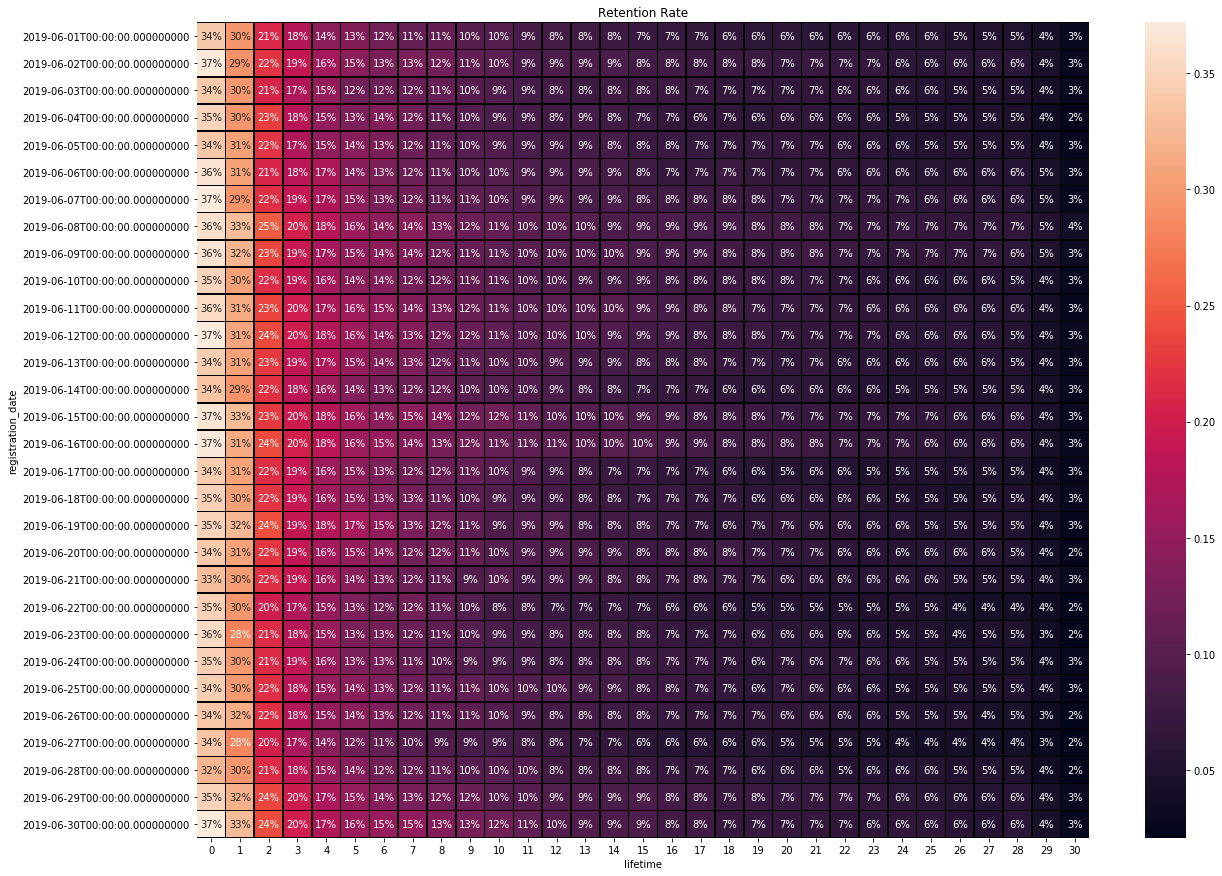

In [15]:
plt.figure(figsize=(20, 15))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.0%', linewidths=0.5, linecolor='black');

### 2. Считаем выручку ARPU
Получим данные о выручке по дням в разрезе когорт, для пользователей, зарегистрировавшихся в июне 2019 г.

In [16]:
def getRevenue():
    query = """SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    """.format()
    conn = psycopg2.connect("""dbname='' user='' host='' password='' port=5432""")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue = pd.DataFrame(getRevenue())

Посмотрим информацию по колонкам: 

In [17]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      833 non-null    object 
 1   registration_date         833 non-null    object 
 2   users_count_with_revenue  833 non-null    int64  
 3   revenue                   833 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.2+ KB


Колонки с датами содержат тип object. Произведем преобразование к типу datetime:

In [18]:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

#### Объединяем датафреймы

Следующим шагом нужно объединить данные датафрейма revenue с данными датафрейма retention_table. 

Предварительно изменим название колонки date на activity_date в датафрейме revenue. 

In [19]:
revenue = revenue.rename(columns={'date':'activity_date'})

In [20]:
# Теперь можно объединить датафреймы:
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')

Посмотрим на информацию, содержащуюся в объединенном датафрейме:

In [21]:
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1651,4833,0.341610,0,1082.0,1611.860
1,2019-06-02,2019-06-01,1429,4833,0.295676,1,928.0,317.738
2,2019-06-02,2019-06-02,1933,5255,0.367840,0,1257.0,1305.220
3,2019-06-03,2019-06-01,1021,4833,0.211256,2,623.0,192.273
4,2019-06-03,2019-06-02,1550,5255,0.294957,1,1008.0,554.859


In [22]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 929
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             930 non-null    datetime64[ns]
 1   registration_date         930 non-null    datetime64[ns]
 2   active_users_count        930 non-null    int64         
 3   registered_users_count    930 non-null    int64         
 4   retention_rate            930 non-null    float64       
 5   lifetime                  930 non-null    int32         
 6   users_count_with_revenue  833 non-null    float64       
 7   revenue                   833 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2)
memory usage: 61.8 KB


Произведем преобразования: заменим пропущенные значения на 0 и преобразуем тип в колонке users_count_with_revenue в целочисленный:

In [23]:
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)

In [24]:
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

#### Подсчитаем показатель ARPU:

In [25]:
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue'] / retention_table_with_revenue['active_users_count']
retention_table_with_revenue['arpu']

0      0.976293
1      0.222350
2      0.675230
3      0.188318
4      0.357974
         ...   
925    0.225250
926    0.000000
927    0.061347
928    0.069819
929    0.126429
Name: arpu, Length: 930, dtype: float64

#### Построим сводную таблицу, которая отражает изменение ARPU по когортам июня 2019 г. в зависимости от времени жизни

In [26]:
arpu_pivot = retention_table_with_revenue.pivot_table(index='registration_date',columns='lifetime',values='arpu',aggfunc='sum')
print(arpu_pivot)

lifetime                 0         1         2         3         4         5   \
registration_date                                                               
2019-06-01         0.976293  0.222350  0.188318  0.090474  0.056714  0.215960   
2019-06-02         0.675230  0.357974  0.213420  0.126478  0.052536  0.213401   
2019-06-03         0.717116  0.243213  0.043576  0.126431  0.093071  0.437531   
2019-06-04         0.570125  0.280646  0.156369  0.249738  0.207717  0.313095   
2019-06-05         0.678426  0.053987  0.524198  0.164261  0.200625  0.003562   
2019-06-06         0.864330  0.156215  0.295781  0.367368  0.192799  0.059184   
2019-06-07         0.488339  0.439912  0.276970  0.192135  0.182919  0.572635   
2019-06-08         0.653629  0.415474  0.192290  0.268525  0.276235  0.334379   
2019-06-09         0.910159  0.186660  0.207617  0.137292  0.441263  0.104410   
2019-06-10         0.862795  0.345660  0.164179  0.103478  0.079035  0.246970   
2019-06-11         0.405877 

#### Построим тепловую карту, показывающую изменение ARPU

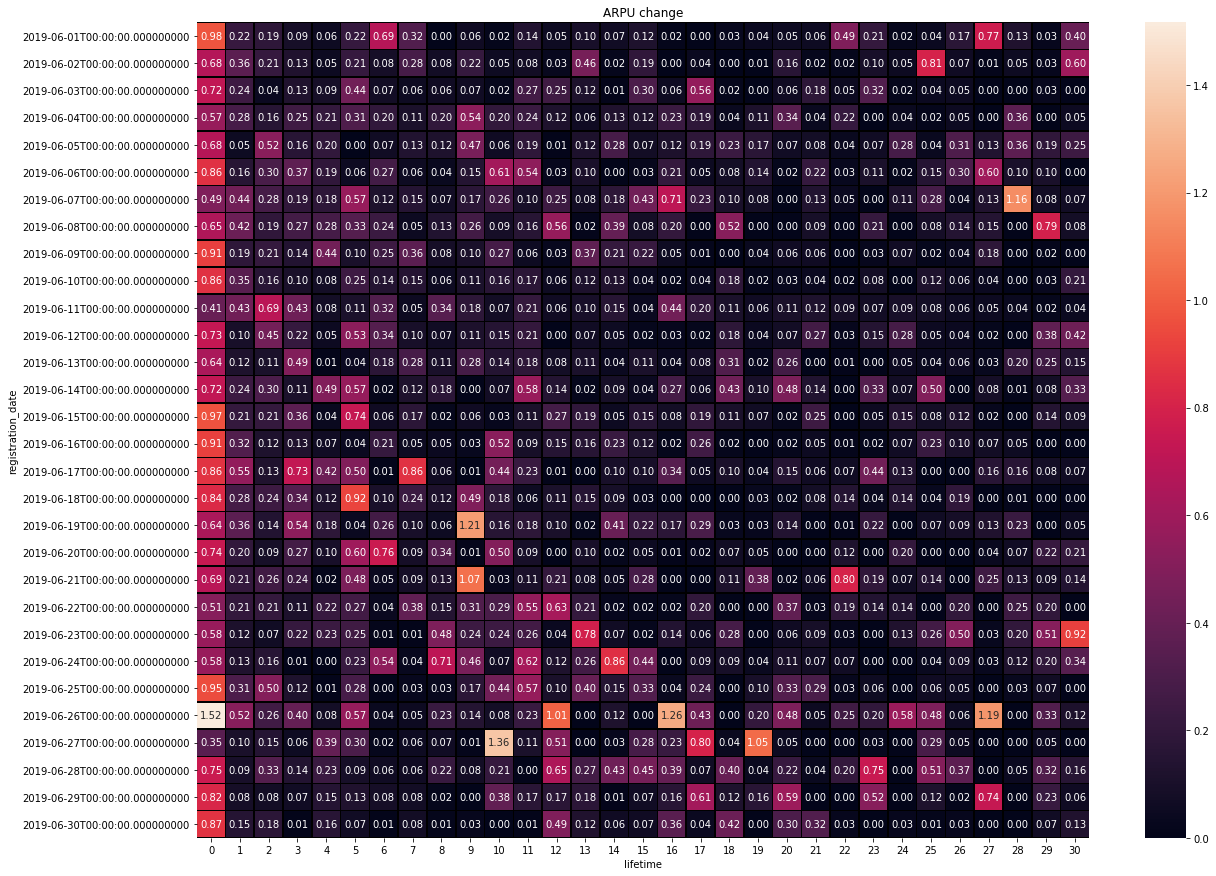

In [27]:
plt.figure(figsize=(20, 15))
plt.title('ARPU change')
sns.heatmap(arpu_pivot, annot=True, fmt='.2f', linewidths=0.5, linecolor='black');

#### Посмотрим на графике как изменяется показатель ARPU по когортам июня 2019 г. в нулевой день:

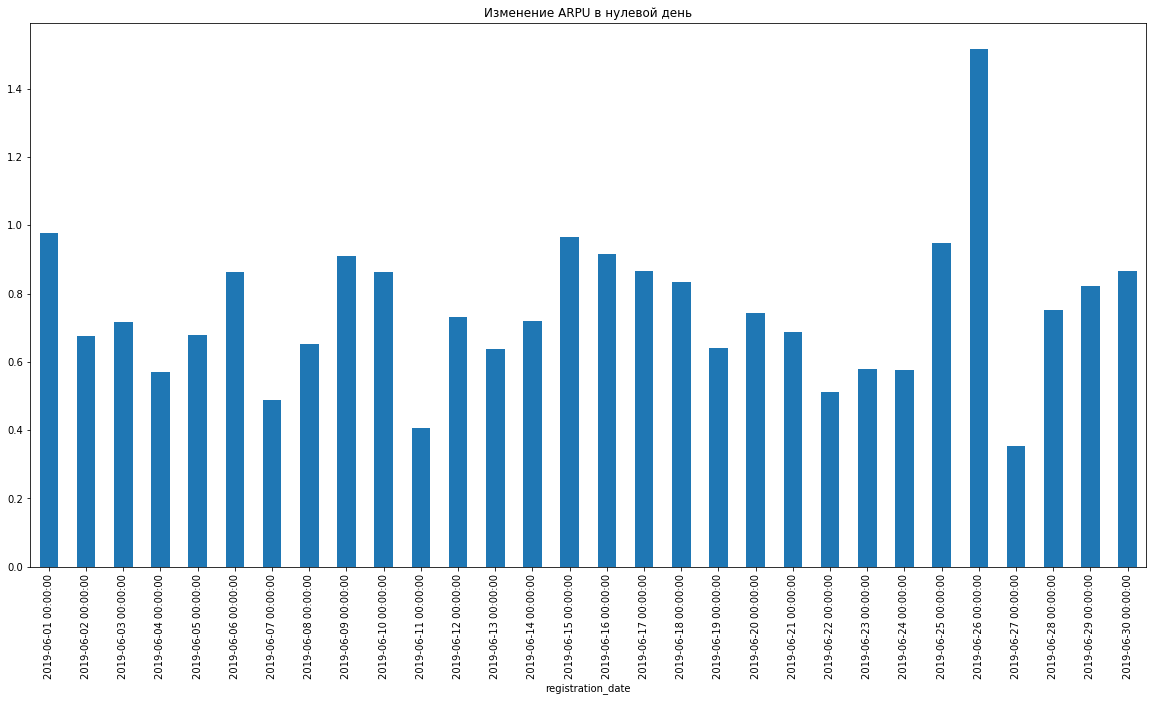

In [28]:
plt.figure(figsize=(20, 10))
plt.title('Изменение ARPU в нулевой день')
arpu_pivot[0].plot.bar()

Вывод: показатель ARPU в течение июня 2019 г. изменяется неравномерно, есть падения средней выручки - особенно 11.06.2019 и 27.06.2019, есть резкий рост средней выручки - 26.06.2019.

#### Определим средний ARPU в июне 2019 г. в зависимости от времени жизни пользователя

In [29]:
arpu_mean_by_lifetime = arpu_pivot.mean()
print (arpu_mean_by_lifetime )

lifetime
0     0.748997
1     0.247612
2     0.231219
3     0.226372
4     0.161454
5     0.308641
6     0.175224
7     0.153147
8     0.140943
9     0.234994
10    0.237923
11    0.216741
12    0.208700
13    0.158504
14    0.148857
15    0.148024
16    0.187117
17    0.167570
18    0.134404
19    0.100599
20    0.153664
21    0.094581
22    0.099685
23    0.144491
24    0.091224
25    0.153679
26    0.108511
27    0.161853
28    0.124374
29    0.150843
30    0.162709
dtype: float64


#### Построим график изменения среднего ARPU по когортам в июне 2019 г. в зависимости от времени жизни пользователя.

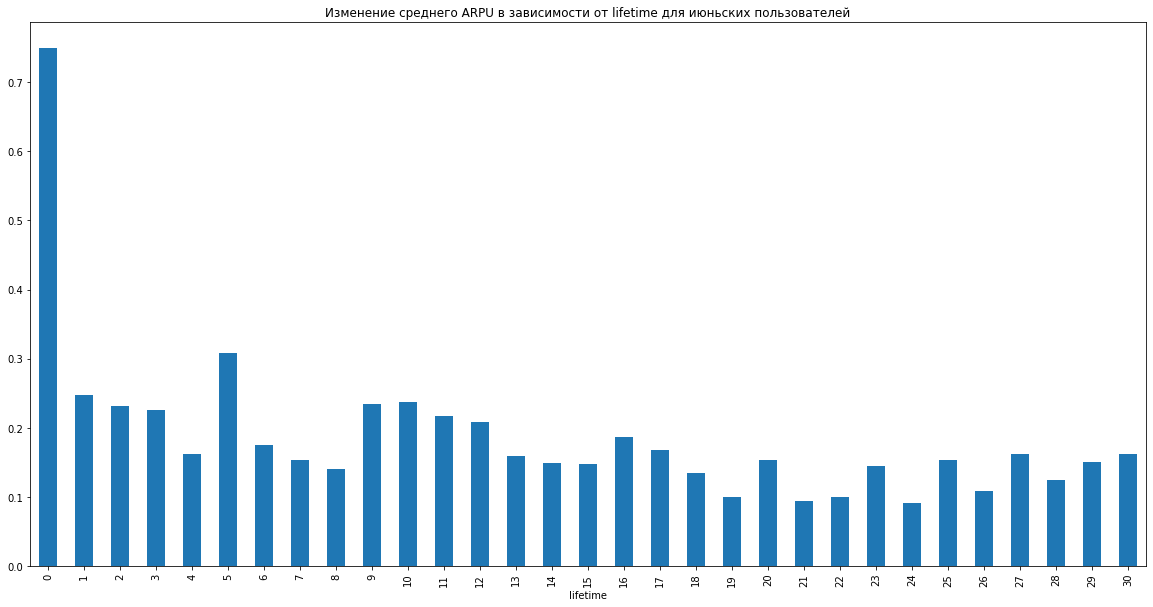

In [30]:
plt.figure(figsize=(20, 10))
plt.title('Изменение среднего ARPU в зависимости от lifetime для июньских пользователей')
arpu_mean_by_lifetime.plot.bar()

#### Вывод:
Как видно по графику, в начале месяца происходит наибольший рост среднего ARPU: нулевой день дает максимальный рост и далее в 5 день наблюдается высокий рост средней выручки. В дальнейшем с 9 по 10 день равномерный рост ARPU, с 11 дня снижение и далее чередуется рост со снижением до конца месяца.